# Assignment: The observation and interpretation of turbulence dissipation

The goal of the accompanying assignment is to become familiar with working with and interpreting observations of the rate of dissipation of turbulence. 
The assignment is presented in Python, and while any coding language of preference can be used, the easiest would be to ensure that you have an updated version of python working on your local machine with the following dependencies: numpy, scipy, matplotlib, pandas, xarray (including h5netcdf) and gsw.
An environment.yml file is provided in the folder `assignments` which will install all nessecary dependencies provided you have the Anaconda distribution installed. 
From your terminal, run ```conda env create -f environment.yml```, then ```conda activate turbulence```  
Check that the python packages required are installed and adjust paths to your local machine if needed.   

Completion and submission of the assignment is nessecary for completing the course. 

---

Turbulent flow is ubiquitous, but not homogeneously distributed. 

One method for observing turbulence is the observation of microstructure shear, from which the rate of turbulence dissipation can be directly computed. Such observations are crucial for understanding the contributions of various sources of turbulence production in the ocean, the turbulence flux of properties and the processes by which TKE is dissipated. 

In this assignment, you will become familiar with the analysis of profiles of the dissipation rate of TKE under a range of forcing conditions. 

Best practices for the processing of microstructure shear data are described in {cite}`lueck_best_2024` with benchmark datasets described by {cite}`fer_2024`.  



In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import pandas as pd
import gsw

In [2]:
# A function we will use later

def Nasfunc(x,eps,vis=1.6e-6):
    """ out=Nasfunc(x,eps,vis)
     x is the wavenumber, eps is the dissipation
     returns the Nasmyth's dissipation spectrum.
     The function form is given in Lueck et
     J. Oceanogr. 2002.
     default vis=1.6e-6 #m2/s kinematic viscocity
     See also Nasfunc_log"""

    ks = (eps*(vis**-3))**(1/4)
    x1= x/ks

    #fit provided by Fabian Wolk -see Lueck et al paper in J. Oceanogr. 2002
    G=(8.05*(x1**(1/3))) / (1+ ((20*x1)**3.7))
    return ((ks**2)*((eps*(vis**5))**(1/4)))*G   #in s-2/cpm

## Part I

Become familiar with the observation of microstructure shear

### Baltic Sea - A quiescent region

```{figure} images/microstructure_probe_mss.png
:name: fig-mss
:width: 15%
:align: center

A Sea and Sun Technology Microstructure Probe.
```

This dataset can be downloaded here:

Holtermann, P. ATOMIX shear probes benchmark data: Example microstructure data from a Sea & Sun Technology MSS microstructure profiler, Bornholm Basin, Baltic Sea. NERC EDS British Oceanographic Data Centre NOC., https://doi.org/10.5285/0e35f96f-57e3-540b-e063-6c86abc06660 (2024).

The Baltic Sea profile was taken in September 2008 in the Bornholm Basin from the Research Vessel Poseidon. The oceanographic context and a detailed analysis of the data collected during this cruise are given in van der Lee and Umlauf (2011). The total depth was about 85 m. The instrument used was a MSS-Microstructure profiler with the serial number 38, produced by Sea & Sun Technology, Germany. It was equipped with two randomly oriented shear probes, one FP07 thermistor, and one PT100 temperature sensor and a conductivity cell for precision temperature and salinity measurements. The probe was also fitted with a vibration sensor, which is similar in design to a shear probe sensor, except that the airfoil is replaced by a small mass and is mounted inside the probe. The probe was connected with a cable to a ship-board data acquisition system and was operated with an electrical winch from the stern of the ship. During the profiling, the ship slowly moved along a transect with a speed of approximately 0.5 m s−1. The transect was oriented such that wind and surface currents came from the bow, such that the loosely tethered cable was always at a safe distance to the ship’s propeller. Using a sensor protection cage, it was possible to obtain nearly full-depth vertical profiles to within 0.1 m above the seafloor, with a descent speed of approximately 0.5 m s−1 .  

**First we will take a look at a few metrics to get familiar with dissipation data**


In [3]:
# The data is stored as a grouped NetCDF file.
# First look at the global attributes.
dat_b=xr.open_dataset('assignment/baltic/MSS_Baltic.nc', engine="h5netcdf",group="")
dat_b.attrs

{'title': 'Example microstructure data from a Sea & Sun Technology MSS microstructure profiler',
 'summary': 'Vertical microstructure profile',
 'comment': 'The profile was collected on 20-Sep-2008 during the cruise POS373 onboard R.V. Poseidon, using the tethered free-fall MSS90-L profiler (Sea & Sun Technology, Germany, SN038). The dissipation rate was measured using two airfoil shear probes. In addition a fast-response FP07 thermistor, pressure, temperature, conductivity, vibration and oxygen sensors were mounted. All sensor were sampled with 1024 Hz. The processing of the data and the format of this data set follows the recommendations and guidelines of the SCOR Working Group #160, ATOMIX (https://wiki.uib.no/atomix). The netCDF file includes four hierarchical groups, corresponding to the four levels of microstructure data in the ATOMIX format. L1_converted : time series from all sensors converted into physical units L2_cleaned : selected signals that are filtered and/or despiked b

In [32]:
# open each group separately

dat_bL1=xr.open_dataset('assignment/baltic/MSS_Baltic.nc', engine="h5netcdf",group="L1_converted")
dat_bL2=xr.open_dataset('assignment/baltic/MSS_Baltic.nc', engine="h5netcdf",group="L2_cleaned")
dat_bL3=xr.open_dataset('assignment/baltic/MSS_Baltic.nc', engine="h5netcdf",group="L3_spectra")
dat_bL4=xr.open_dataset('assignment/baltic/MSS_Baltic.nc', engine="h5netcdf",group="L4_dissipation")

In [36]:
dat_bL4

<xarray.Dataset> Size: 13kB
Dimensions:         (TIME_SPECTRA: 61, N_SHEAR_SENSORS: 2)
Dimensions without coordinates: TIME_SPECTRA, N_SHEAR_SENSORS
Data variables: (12/16)
    TIME            (TIME_SPECTRA) datetime64[ns] 488B ...
    EPSI            (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    EPSI_FINAL      (TIME_SPECTRA) float64 488B ...
    SECTION_NUMBER  (TIME_SPECTRA) float64 488B ...
    PSPD_REL        (TIME_SPECTRA) float64 488B ...
    PRES            (TIME_SPECTRA) float64 488B ...
    ...              ...
    EPSI_STD        (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    N_S             (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    KMAX            (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    KMIN            (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    EPSI_FLAGS      (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...
    METHOD          (N_SHEAR_SENSORS, TIME_SPECTRA) float64 976B ...

#### Plot vertical profile of temperature

1.1 Describe what you can about the hydrographic structure from this plot. Can refer to {cite}`lee_umlauf_2011` for context.

Text(0.5, 0, 'Temperature [°C]')

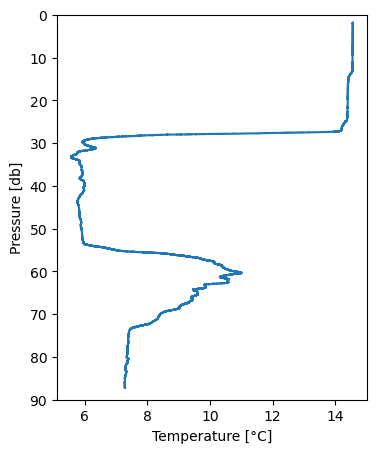

In [5]:
plt.figure(figsize=(4,5))
plt.plot(dat_bL1.TEMP_CTD,dat_bL1.PRES)
plt.ylim(90,0)
plt.ylabel('Pressure [db]')
plt.xlabel('Temperature [°C]')

#### Plot time series 
Below are time series of a) Pressure and Velocity through water, b) vertical shear, c) platform vibrations and d) turbulence dissipation rate.   

1.2) Interpret what might be causing enhanced vibrations in c.  
1.3a) Describe the vertical profile of the dissipation rate of turbulence (where dissipation rate is high, where it is low) with reference to the distance from the surface and the temperature profile.  
1.3b) Select two points, one with high dissipation rate and one with low dissipation rate and overlay vertical lines at these chosen points in subpanels d).

Text(0.5, 0, 'time')

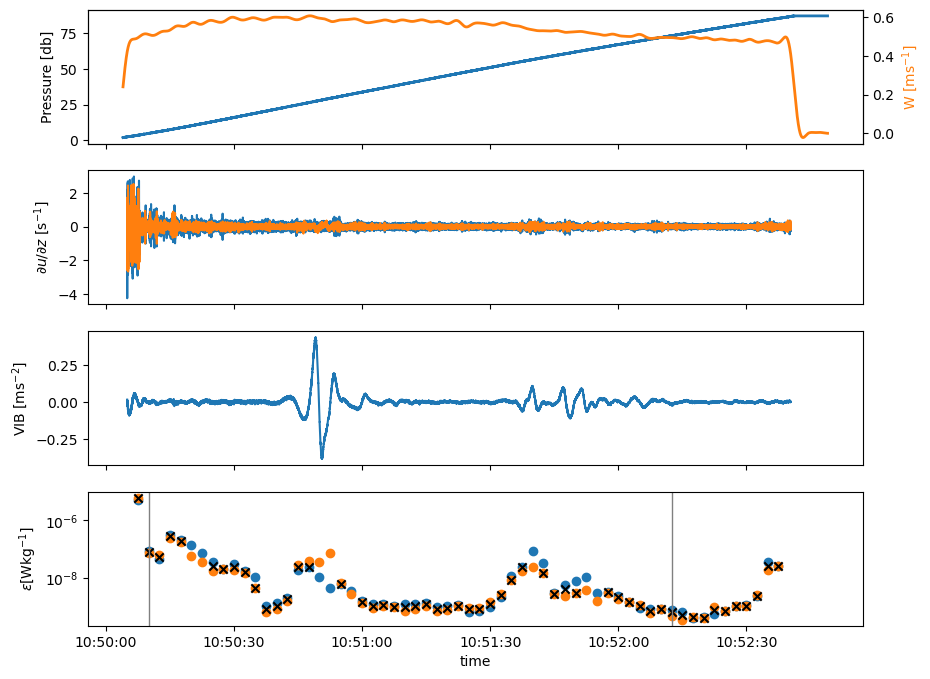

In [37]:
fig,ax=plt.subplots(4,1,figsize=(10,8),sharex=True)

ax[0].plot(dat_bL1.TIME,dat_bL1.PRES,lw=2)
ax[0].set_ylabel('Pressure [db]')

axa=ax[0].twinx()
axa.plot(dat_bL1.TIME,dat_bL1.PSPD_REL,c='tab:orange',lw=2)
axa.set_ylabel('W [ms$^{-1}$]',c='tab:orange')


ax[1].plot(dat_bL2.TIME,dat_bL2.SHEAR[0,:])
ax[1].plot(dat_bL2.TIME,dat_bL2.SHEAR[1,:])

ax[1].set_ylabel(r'$\partial u / \partial z$ [s$^{-1}$]')

ax[2].plot(dat_bL2.TIME,dat_bL2.VIB[0,:])
ax[2].set_ylabel(r'VIB [ms$^{-2}$]')


ax[3].scatter(dat_bL4.TIME,dat_bL4.EPSI[0,:],label=r'$\epsilon_1$')
ax[3].scatter(dat_bL4.TIME,dat_bL4.EPSI[1,:],label=r'$\epsilon_2$')
ax[3].scatter(dat_bL4.TIME,dat_bL4.EPSI_FINAL,c='k',marker='x',label=r'$\epsilon$')


### EDIT HERE, only dummies used
# 1.3b: identify two regions of dissipation (strong versus quiescent) 
i= 1   # strong dissipation
j= 50   # weak dissipation

ax[3].axvline(pd.to_datetime(dat_bL4.TIME[i].values),c='grey',lw=1)
ax[3].axvline(pd.to_datetime(dat_bL4.TIME[j].values),c='grey',lw=1)

ax[3].set_yscale('log')
ax[3].set_ylabel(r'$\epsilon \mathrm{[W kg^{-1}]}$')
ax[3].set_xlabel('time')



#### Create model Nasmyth Spectra for chosen dissipation rates in the data
1.4) Using the Nasmyth model, create spectra for your selected dissipation rates. 

In [38]:
# print dissipation values for chosen spectra and create model nasmyth shear spectra

knas_strong = np.linspace(0,100,len(dat_bL3.KCYC[:,i]))
print(dat_bL4.EPSI_FINAL[i])
nasmyth_strong = Nasfunc(knas_strong,dat_bL4.EPSI_FINAL[i].values)

print(dat_bL4.EPSI_FINAL[j])
knas_weak = np.linspace(0,100,len(dat_bL3.KCYC[:,j]))
nasmyth_weak = Nasfunc(knas_weak,dat_bL4.EPSI_FINAL[j].values)


<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(7.880893e-08)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...
<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(6.033673e-10)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...


#### Dissipation estimates from shear spectra

Look at the agreement between dissipation estimates from the two spectra. Generally, turbulence can be observed to within a factor of two {cite}`moum_comparison_1995`.   

1.5) Plot shear spectra at the two dissipation rates that you chose earlier. How does shear spectra relate to dissipation rates? 

Text(0, 0.5, '$\\Psi$ $[s^{-2}\\mathrm{cpm}^{-1}]$')

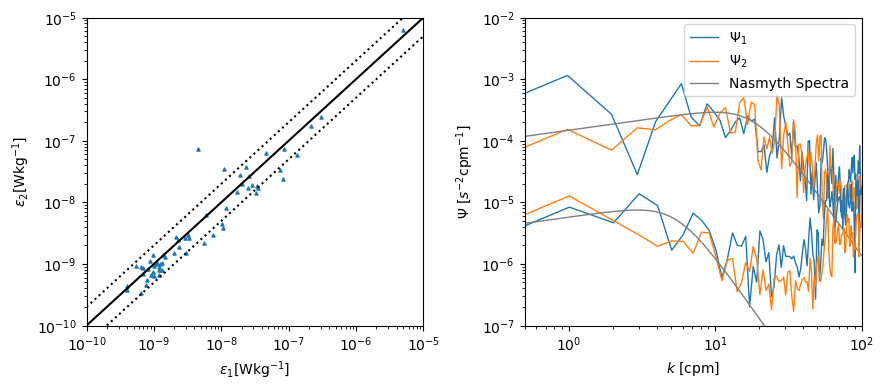

In [39]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

## Dissipation plot

ax[0].scatter(dat_bL4.EPSI[0,:],dat_bL4.EPSI[1,:],marker='^',s=5)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

# Define the range for the 1-to-1 and confidence interval lines
x_vals = np.logspace(-10, 
                     -5, 100)

# Plot 1:1 line
ax[0].plot(x_vals, x_vals, 'k')

# Plot factor of 2 confidence intervals
ax[0].plot(x_vals, 2 * x_vals, 'k:')
ax[0].plot(x_vals, 0.5* x_vals, 'k:')

ax[0].set_ylim(1e-10,1e-5)
ax[0].set_xlim(1e-10,1e-5)

ax[0].set_xlabel(r'$\epsilon_1 \mathrm{[W kg^{-1}]}$')
ax[0].set_ylabel(r'$\epsilon_2 \mathrm{[W kg^{-1}]}$')


## Spectra

ax[1].plot(dat_bL3.KCYC[:,i],dat_bL3.SH_SPEC_CLEAN[0,:,i],c='tab:blue',lw=1,label=r'$\Psi_{1}$')
ax[1].plot(dat_bL3.KCYC[:,i],dat_bL3.SH_SPEC_CLEAN[1,:,i],c='tab:orange',lw=1,label=r'$\Psi_{2}$')
ax[1].plot(knas_strong,nasmyth_strong,c='grey',lw=1,label='Nasmyth Spectra')

ax[1].plot(dat_bL3.KCYC[:,j],dat_bL3.SH_SPEC_CLEAN[0,:,j],c='tab:blue',lw=1)
ax[1].plot(dat_bL3.KCYC[:,j],dat_bL3.SH_SPEC_CLEAN[1,:,j],c='tab:orange',lw=1)
ax[1].plot(knas_weak,nasmyth_weak,c='grey',lw=1)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_xlim(0.5,1e2)
ax[1].set_ylim(1e-7,1e-2)

ax[1].legend()

ax[1].set_xlabel(r'$k$ [cpm]')
ax[1].set_ylabel(r'$\Psi$ $[s^{-2}\mathrm{cpm}^{-1}]$')



### Haro Straight - A tidal channel.

```{figure} images/vmp250.png
:name: fig-vmp
:width: 40%
:align: center

A Rockland Scientific VMP250.
```
This dataset can be downloaded here:

Lueck, R. ATOMIX shear probes benchmark data: a dissipation profile from Haro Strait, British Columbia, Canada obtained with a vertical microstructure profiler in October 2016. NERC EDS British Oceanographic Data Centre NOC., https://doi.org/10.5285/0ec16a65-abdf-2822-e063-6c86abc06533 (2024).

This turbulence profile was taken in a side channel adjacent to Haro Strait on the east coast of Vancouver Island, British Columbia, Canada, on 19 October 2016. The instrument was a VMP-250-IR (internally recording and serial number 215) vertical profiler from Rockland Scientific, Canada. It was configured to collect data while descending, with two shear probes oriented to measure two orthogonal components of the vertical shear of horizontal current, one FP07 thermistor, and two vibration sensors, all of which were anti-alias low-pass filtered at 98 Hz and sampled at a rate of 512 s−1. 

In [40]:
# First look at the global attributes
dat_h=xr.open_dataset('assignment/haro_straight/VMP250_TidalChannel_024.nc', engine="h5netcdf",group="")
dat_h.attrs

{'authors': 'Rolf Lueck',
 'type': 'Time series from a VMP',
 'source': 'VMP-250',
 'platform_type': 'Research Vessel',
 'title': 'ATOMIX shear probes benchmark data: a dissipation profile from Haro Strait, British Columbia, Canada obtained with a vertical microstructure profiler in October 2016',
 'summary': 'This file was processed using a speed equal to the rate-of-change of pressure. The profile was collected using a tethered free-fall vertical microstructure profiler (VMP-250IR, Rockland Scientific, Canada), prepared as a benchmark shear-probe data example for the Scientific Committee on Oceanographic Research (SCOR) Working Group #160, "Analyzing ocean turbulence observations to quantify mixing" (ATOMIX, https://wiki.uib.no/atomix). The profile was collected on 2016-10-19 17:49:11 from R.V. Strickland in Haro Strait for a demonstration class. The bottom depth at this location is approximately 80 meters. The dissipation rate was measured using two airfoil shear probes. The dataset

In [41]:
dat_hL1=xr.open_dataset('assignment/haro_straight/VMP250_TidalChannel_024.nc', engine="h5netcdf",group="L1_converted")
dat_hL2=xr.open_dataset('assignment/haro_straight/VMP250_TidalChannel_024.nc', engine="h5netcdf",group="L2_cleaned")
dat_hL3=xr.open_dataset('assignment/haro_straight/VMP250_TidalChannel_024.nc', engine="h5netcdf",group="L3_spectra")
dat_hL4=xr.open_dataset('assignment/haro_straight/VMP250_TidalChannel_024.nc', engine="h5netcdf",group="L4_dissipation")


#### Plot vertical profile of temperature, salinity and density

1.6 Describe what you can about the hydrographic structure from this plot.

In [42]:
# calculate salinity and density using the TEOS GSW package. 

SP=gsw.SP_from_C(dat_hL1.COND[0,:],dat_hL1.TEMP,dat_hL1.PRES)
SA=gsw.SA_from_SP(SP,dat_hL1.PRES,-123,48)
CT =gsw.CT_from_t(SA,dat_hL1.TEMP,dat_hL1.PRES)
rho=gsw.rho(SA,CT,dat_hL1.PRES)


Text(0.5, 0, 'Density [kgm$^{-3}$]')

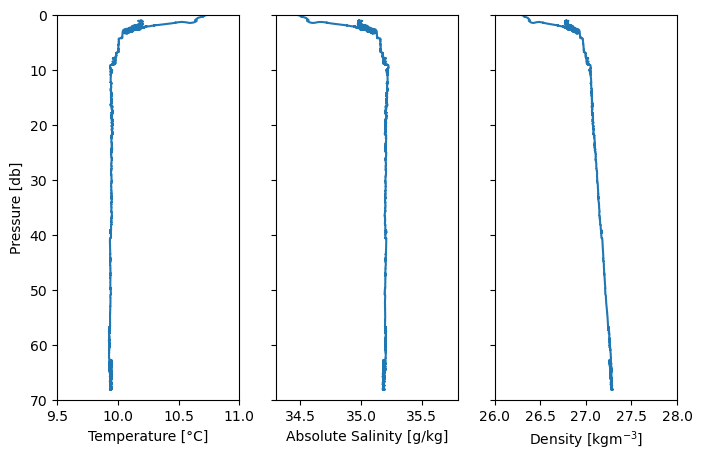

In [43]:
fig,ax=plt.subplots(1,3,figsize=(8,5),sharey=True)
ax[0].plot(CT,dat_hL1.PRES)
ax[0].set_ylim(70,0)
ax[0].set_xlim(9.5,11)
ax[0].set_ylabel('Pressure [db]')
ax[0].set_xlabel('Temperature [°C]')

ax[1].plot(SA,dat_hL1.PRES)
ax[1].set_xlim(34.3,35.8)
ax[1].set_xlabel('Absolute Salinity [g/kg]')

ax[2].plot(rho-1000,dat_hL1.PRES)
ax[2].set_xlim(26,28)
ax[2].set_xlabel('Density [kgm$^{-3}$]')


#### Plot time series 
Like before, below are time series of a) Pressure and Velocity through water, b) vertical shear, c) platform vibrations and d) turbulence dissipation rate.   

1.7) Interpret what might be causing the enhanced vertical shear in b) with reference to the platofrms velocity through water.  
1.8a) Describe the vertical profile of the dissipation rate of turbulence (where dissipation rate is high, where it is low) with reference to the distance from the surface and the temperature profile. Comment on differences to the previous profile in the Baltic Sea. 
1.8b) Select two points, one with high dissipation rate and one with low dissipation rate and overlay vertical lines at these chosen points in subpanels d).

Text(0.5, 0, 'time')

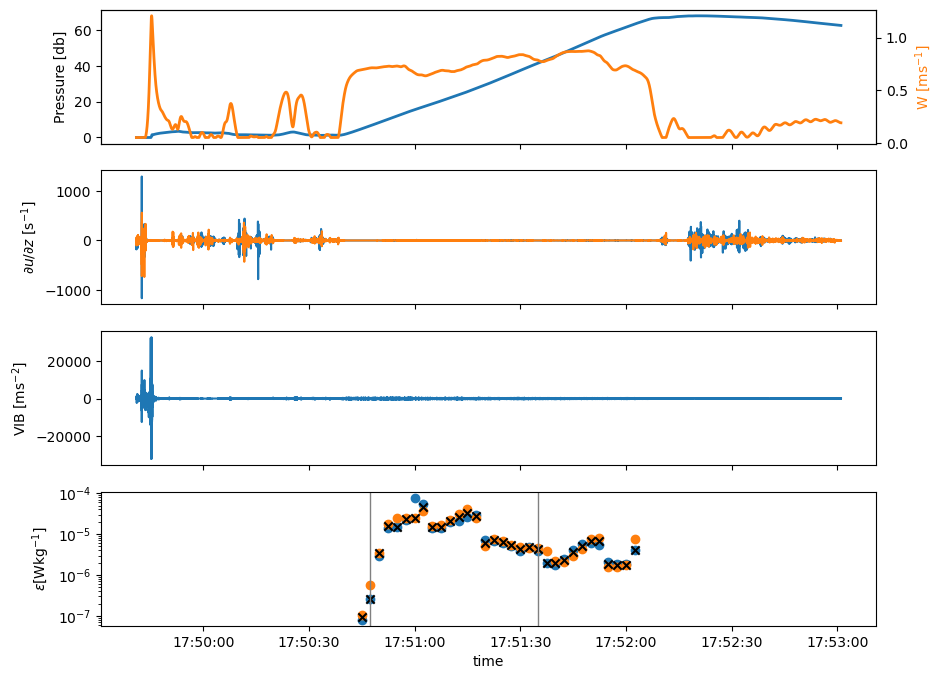

In [46]:
fig,ax=plt.subplots(4,1,figsize=(10,8),sharex=True)

ax[0].plot(dat_hL1.TIME,dat_hL1.PRES,lw=2)
ax[0].set_ylabel('Pressure [db]')

axa=ax[0].twinx()
axa.plot(dat_hL2.TIME,dat_hL2.PSPD_REL,c='tab:orange',lw=2)
axa.set_ylabel('W [ms$^{-1}$]',c='tab:orange')


ax[1].plot(dat_hL2.TIME,dat_hL2.SHEAR[0,:])
ax[1].plot(dat_hL2.TIME,dat_hL2.SHEAR[1,:])

ax[1].set_ylabel(r'$\partial u / \partial z$ [s$^{-1}$]')

ax[2].plot(dat_hL2.TIME,dat_hL2.VIB[0,:])
ax[2].set_ylabel(r'VIB [ms$^{-2}$]')


ax[3].scatter(dat_hL4.TIME,dat_hL4.EPSI[0,:],label=r'$\epsilon_1$')
ax[3].scatter(dat_hL4.TIME,dat_hL4.EPSI[1,:],label=r'$\epsilon_2$')
ax[3].scatter(dat_hL4.TIME,dat_hL4.EPSI_FINAL,c='k',marker='x',label=r'$\epsilon$')


### EDIT HERE, only dummies used
#identify two regions of dissipation (strong versus quiescent) 
i= 20   # strong dissipation
j= 1   # weak dissipation

ax[3].axvline(pd.to_datetime(dat_hL4.TIME[i].values),c='grey',lw=1)
ax[3].axvline(pd.to_datetime(dat_hL4.TIME[j].values),c='grey',lw=1)

ax[3].set_yscale('log')
ax[3].set_ylabel(r'$\epsilon \mathrm{[W kg^{-1}]}$')
ax[3].set_xlabel('time')



#### Create model Nasmyth Spectra for chosen dissipation rates in the data

In [47]:
# print dissipation values for chosen spectra and create model nasmyth shear spectra

knas_strong = np.linspace(0,100,len(dat_hL3.KCYC[:,i]))
print(dat_hL4.EPSI_FINAL[i])
nasmyth_strong = Nasfunc(knas_strong,dat_hL4.EPSI_FINAL[i].values)

print(dat_hL4.EPSI_FINAL[j])
knas_weak = np.linspace(0,100,len(dat_hL3.KCYC[:,j]))
nasmyth_weak = Nasfunc(knas_weak,dat_hL4.EPSI_FINAL[j].values)


<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(4.216252e-06)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...
<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(2.579372e-07)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...


#### Dissipation estimates from shear spectra

Look at the agreement between dissipation estimates from the two spectra. Generally, turbulence can be observed to within a factor of two.   

1.9) Plot shear spectra at the two dissipation rates that you chose earlier. How does shear spectra relate to dissipation rates? 

Text(0, 0.5, '$\\Psi$ $[s^{-2}\\mathrm{cpm}^{-1}]$')

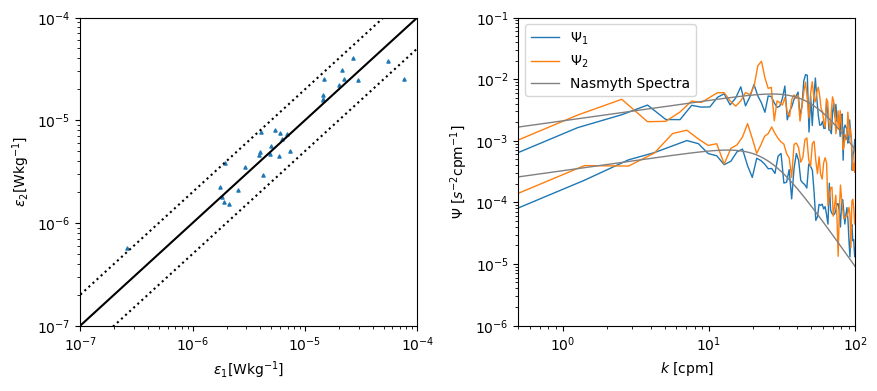

In [51]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

## Dissipation plot

ax[0].scatter(dat_hL4.EPSI[0,:],dat_hL4.EPSI[1,:],marker='^',s=5)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

# Define the range for the 1-to-1 and confidence interval lines
x_vals = np.logspace(-7, 
                     -4, 100)

# Plot 1:1 line
ax[0].plot(x_vals, x_vals, 'k')

# Plot factor of 2 confidence intervals
ax[0].plot(x_vals, 2 * x_vals, 'k:')
ax[0].plot(x_vals, 0.5* x_vals, 'k:')

ax[0].set_ylim(1e-7,1e-4)
ax[0].set_xlim(1e-7,1e-4)

ax[0].set_xlabel(r'$\epsilon_1 \mathrm{[W kg^{-1}]}$')
ax[0].set_ylabel(r'$\epsilon_2 \mathrm{[W kg^{-1}]}$')


## Spectra

ax[1].plot(dat_hL3.KCYC[:,i],dat_hL3.SH_SPEC_CLEAN[0,:,i],c='tab:blue',lw=1,label=r'$\Psi_{1}$')
ax[1].plot(dat_hL3.KCYC[:,i],dat_hL3.SH_SPEC_CLEAN[1,:,i],c='tab:orange',lw=1,label=r'$\Psi_{2}$')
ax[1].plot(knas_strong,nasmyth_strong,c='grey',lw=1,label='Nasmyth Spectra')

ax[1].plot(dat_hL3.KCYC[:,j],dat_hL3.SH_SPEC_CLEAN[0,:,j],c='tab:blue',lw=1)
ax[1].plot(dat_hL3.KCYC[:,j],dat_hL3.SH_SPEC_CLEAN[1,:,j],c='tab:orange',lw=1)
ax[1].plot(knas_weak,nasmyth_weak,c='grey',lw=1)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_xlim(0.5,1e2)
ax[1].set_ylim(1e-6,1e-1)

ax[1].legend()

ax[1].set_xlabel(r'$k$ [cpm]')
ax[1].set_ylabel(r'$\Psi$ $[s^{-2}\mathrm{cpm}^{-1}]$')

## Part II

Use observations of microstructure shear to understand turbulent processes in the ocean

### Weddell Sea

```{figure} images/microrider_slocum.png
:name: fig-mr_slocum
:width: 40%
:align: center

A Rockland Scientific Microrider mounted on top of a Slocum glider.
```

In this part, we will focus on a dataset collected by a Rocklands Scientific Microrider that was mounted on a Slocum glider and deployed in the seasonal sea-ice region of the Weddell Sea. Refer to {cite}`giddy_vertical_2023` for context. 

As in Part I, start by looking at the spectra and dissipation rates. 

In [52]:
# First look at the global attributes
dat_a=xr.open_dataset('assignment/weddell_sea/DAT_190.nc', engine="h5netcdf",group="")
dat_a.attrs

{'platform_type': 'sub-surface glider',
 'comment': "Ocean turbulence data were collected using a Slocum electric glider as platform. Glider was deployed and recovered during the 2019-2020 SANAE South African Antarctic base resupply cruise on the RV SA Agulhas II. The MR operated continously on both dives and climbs from the surface to a depth of 500 m. The data from the MR include measurements from 2 shear probes, 2-axis piezo-accelerometers (vibration), an inclinometer (pitch and roll) and a pressure transducer. The processing of the data and the format of this data set follows the recommendations and guidelines of the SCOR Working Group 160, ATOMIX (https://wiki.uib.no/atomix), and the processing was done using the standard Matlab tools provided by Rockland Scientific. One NetCDF file per instrument's native file (typically one file per cast) is provided. Each netCDF file includes 4 groups: 4 levels of microstructure data in ATOMIX format. L1_converted : full-resolution data convert

In [53]:
dat_wL1=xr.open_dataset('assignment/weddell_sea/DAT_190.nc', engine="h5netcdf",group="L1_converted")
dat_wL2=xr.open_dataset('assignment/weddell_sea/DAT_190.nc', engine="h5netcdf",group="L2_cleaned")
dat_wL3=xr.open_dataset('assignment/weddell_sea/DAT_190.nc', engine="h5netcdf",group="L3_spectra")
dat_wL4=xr.open_dataset('assignment/weddell_sea/DAT_190.nc', engine="h5netcdf",group="L4_dissipation")


#### Plot vertical profile of temperature, salinity, density and vertical stratification

2.1 Describe what you can about the hydrographic structure from this plot.

In [54]:
# calculate density and stratification
rho=gsw.rho(dat_wL1.SALT,dat_wL1.TEMP_CTD,dat_wL1.PRES_SLOW)

rho_sorted =np.sort(rho) 

# Compute brunt-vaisala frequency 
g=9.8
p0=1025
# n2 = g/p0*(np.diff(rho_sorted)/np.diff(low_res_ctd.z))
drho_dz = np.gradient(rho_sorted, dat_wL1.PRES_SLOW)
n2 = g/p0*drho_dz

def smooth(x, window_len=5):
    return np.convolve(x, np.ones(window_len)/window_len, mode='same')

n2_smooth = smooth(n2, window_len=1000)



/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1290: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1290: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1291: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1291: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1292: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/xnunei/miniconda3/envs/teach/lib/python3.13/site

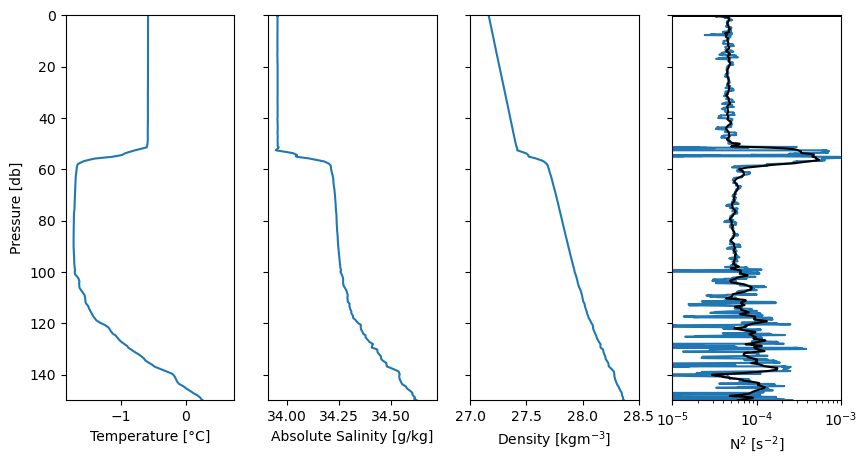

In [55]:
fig,ax=plt.subplots(1,4,figsize=(10,5),sharey=True)
ax[0].plot(dat_wL1.TEMP_CTD,dat_wL1.PRES_SLOW)
ax[0].set_ylim(150,0)
# ax[0].set_xlim(9.5,11)
ax[0].set_ylabel('Pressure [db]')
ax[0].set_xlabel('Temperature [°C]')

ax[1].plot(dat_wL1.SALT,dat_wL1.PRES_SLOW)
# ax[1].set_xlim(34.3,35.8)
ax[1].set_xlabel('Absolute Salinity [g/kg]')

ax[2].plot(rho-1000,dat_wL1.PRES_SLOW)
ax[2].set_xlim(27,28.5)
ax[2].set_xlabel('Density [kgm$^{-3}$]')


ax[3].plot(np.abs(n2),dat_wL1.PRES_SLOW[:])
ax[3].plot(np.abs(n2_smooth),dat_wL1.PRES_SLOW[:],c='k')

ax[3].set_xlim(1e-5,1e-3)
ax[3].set_xlabel('N$^2$ [s$^{-2}$]')
ax[3].set_xscale('log')



#### Plot time series 
Below are time series of a) Pressure and Velocity through water, b) vertical shear, c) platform vibrations and d) turbulence dissipation rate.   

2.2a) Describe the vertical profile of the dissipation rate of turbulence (where dissipation rate is high, where it is low) with reference to the distance from the surface and the temperature profile.  
2.2b) Select two points, one with high dissipation rate and one with low dissipation rate and overlay vertical lines at these chosen points in subpanels d).

Text(0.5, 0, 'time')

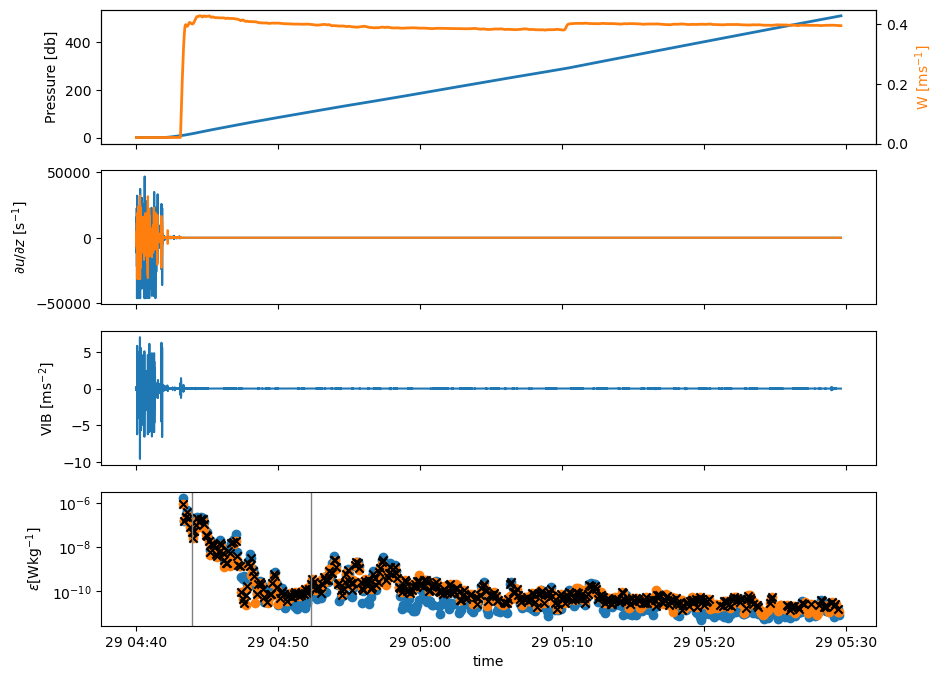

In [72]:
fig,ax=plt.subplots(4,1,figsize=(10,8),sharex=True)

ax[0].plot(dat_wL1.TIME,dat_wL1.PRES,lw=2)
ax[0].set_ylabel('Pressure [db]')

axa=ax[0].twinx()
axa.plot(dat_wL2.TIME,dat_wL2.PSPD_REL,c='tab:orange',lw=2)
axa.set_ylabel('W [ms$^{-1}$]',c='tab:orange')


ax[1].plot(dat_wL2.TIME,dat_wL2.SHEAR[0,:])
ax[1].plot(dat_wL2.TIME,dat_wL2.SHEAR[1,:])

ax[1].set_ylabel(r'$\partial u / \partial z$ [s$^{-1}$]')

ax[2].plot(dat_wL2.TIME,dat_wL2.VIB[0,:])
ax[2].set_ylabel(r'VIB [ms$^{-2}$]')


ax[3].scatter(dat_wL4.TIME,dat_wL4.EPSI[0,:],label=r'$\epsilon_1$')
ax[3].scatter(dat_wL4.TIME,dat_wL4.EPSI[1,:],label=r'$\epsilon_2$')
ax[3].scatter(dat_wL4.TIME,dat_wL4.EPSI_FINAL,c='k',marker='x',label=r'$\epsilon$')

### EDIT HERE, only dummies used
# identify two regions of dissipation (strong versus quiescent) 
i= 6   # strong dissipation
j= 90  # weak dissipation

ax[3].axvline(pd.to_datetime(dat_wL4.TIME[i].values),c='grey',lw=1)
ax[3].axvline(pd.to_datetime(dat_wL4.TIME[j].values),c='grey',lw=1)

ax[3].set_yscale('log')
ax[3].set_ylabel(r'$\epsilon \mathrm{[W kg^{-1}]}$')
ax[3].set_xlabel('time')



#### Create model Nasmyth Spectra for chosen dissipation rates in the data

In [73]:
# print dissipation values for chosen spectra and create model nasmyth shear spectra

knas_strong = np.linspace(0,100,len(dat_wL3.KCYC[:,i]))
print(dat_wL4.EPSI_FINAL[i])
nasmyth_strong = Nasfunc(knas_strong,dat_wL4.EPSI_FINAL[i].values)

print(dat_wL4.EPSI_FINAL[j])
knas_weak = np.linspace(0,100,len(dat_wL3.KCYC[:,j]))
nasmyth_weak = Nasfunc(knas_weak,dat_wL4.EPSI_FINAL[j].values)


<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(4.929667e-08)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...
<xarray.DataArray 'EPSI_FINAL' ()> Size: 8B
array(2.270163e-10)
Attributes:
    standard_name:  specific_turbulent_kinetic_energy_dissipation_in_sea_water
    units:          W kg-1
    long_name:      dissipation rate of turbulent kinetic energy per unit mas...


#### Dissipation estimates from shear spectra

Look at the agreement between dissipation estimates from the two spectra. Generally, turbulence can be observed to within a factor of two.   

2.3) Look at the dissipation estimates from tho probes. At which dissipation rate might you expect to be less condident about the results? 

2.4) Plot shear spectra at the two dissipation rates that you chose earlier. How does shear spectra relate to dissipation rates? 

Text(0, 0.5, '$\\Psi$ $[s^{-2}\\mathrm{cpm}^{-1}]$')

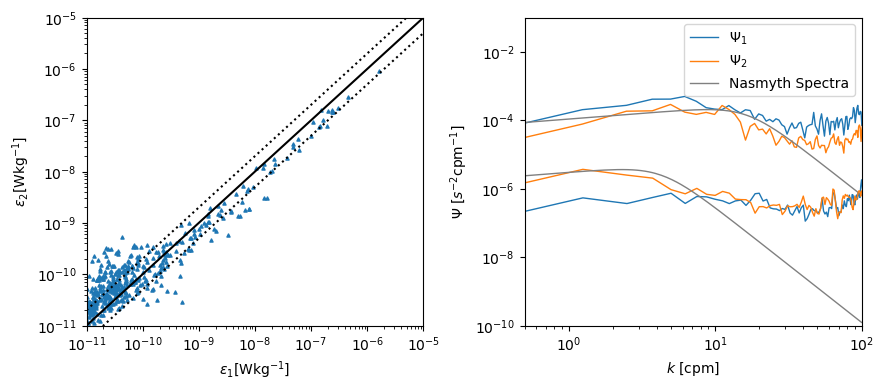

In [74]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

## Dissipation plot

ax[0].scatter(dat_wL4.EPSI[0,:],dat_wL4.EPSI[1,:],marker='^',s=5)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

# Define the range for the 1-to-1 and confidence interval lines
x_vals = np.logspace(-11, 
                     -5, 100)

# Plot 1:1 line
ax[0].plot(x_vals, x_vals, 'k')

# Plot factor of 2 confidence intervals
ax[0].plot(x_vals, 2 * x_vals, 'k:')
ax[0].plot(x_vals, 0.5* x_vals, 'k:')

ax[0].set_ylim(1e-11,1e-5)
ax[0].set_xlim(1e-11,1e-5)

ax[0].set_xlabel(r'$\epsilon_1 \mathrm{[W kg^{-1}]}$')
ax[0].set_ylabel(r'$\epsilon_2 \mathrm{[W kg^{-1}]}$')


## Spectra

ax[1].plot(dat_wL3.KCYC[:,i],dat_wL3.SH_SPEC_CLEAN[0,:,i],c='tab:blue',lw=1,label=r'$\Psi_{1}$')
ax[1].plot(dat_wL3.KCYC[:,i],dat_wL3.SH_SPEC_CLEAN[1,:,i],c='tab:orange',lw=1,label=r'$\Psi_{2}$')
ax[1].plot(knas_strong,nasmyth_strong,c='grey',lw=1,label='Nasmyth Spectra')

ax[1].plot(dat_wL3.KCYC[:,j],dat_wL3.SH_SPEC_CLEAN[0,:,j],c='tab:blue',lw=1)
ax[1].plot(dat_wL3.KCYC[:,j],dat_wL3.SH_SPEC_CLEAN[1,:,j],c='tab:orange',lw=1)
ax[1].plot(knas_weak,nasmyth_weak,c='grey',lw=1)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_xlim(0.5,1e2)
ax[1].set_ylim(1e-10,1e-1)

ax[1].legend()

ax[1].set_xlabel(r'$k$ [cpm]')
ax[1].set_ylabel(r'$\Psi$ $[s^{-2}\mathrm{cpm}^{-1}]$')

#### Compute the vertical turbulent heat flux
Using the Eddy Diffusivity, $Kz$ and following Osborn (1960), calculate the vertical turbulent heat flux.

Assuming the Osborn model for $Kz$:

$$
\mathrm{Kz}=0.2\frac{\epsilon}{N^2}
$$

Note that because the Osborn model for eddy diffusivity is calculated as a function of $N^2$, it will not be valid in conditions of very small $N^2$. Where might this occur?

Heat flux, $F_h$, can be approximated as:

$$
F_h=\rho_0 c_p \mathrm{Kz} \frac{dT}{dz}
$$

2.5) What is the range of Eddy diffusivity? Is this comparable to expected values in the ocean?

2.6) Where is heat flux the strongest? What are possible explanations for the distribution of heat flux in this profile?

In [61]:

#interporate salinity to dissipation spectra
ds_interp = dat_wL1.SALT.interp(
    TIME_SLOW=dat_wL4.TIME
)

SA=ds_interp

# calculate density and stratification
rho=gsw.rho(SA,dat_wL4.TEMP,dat_wL4.PRES)

rho_sorted =np.sort(rho) 

# Compute brunt-vaisala frequency 
g=9.8
p0=1025
# n2 = g/p0*(np.diff(rho_sorted)/np.diff(low_res_ctd.z))
drho_dz = np.gradient(rho_sorted, dat_wL4.PRES)
n2 = g/p0*drho_dz


In [62]:
# Eddy diffusivity, k=0.2 epsilon/N2 
# Osborn Model 

Kz= 0.2*dat_wL4.EPSI_FINAL/np.abs(n2)

<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\ '
/var/folders/1q/qmm9yg_90xl7f60v6q7wn2fr0000gn/T/ipykernel_46724/2509822319.py:18: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\epsilon \ (m^3s^{-2})$')
/var/folders/1q/qmm9yg_90xl7f60v6q7wn2fr0000gn/T/ipykernel_46724/2509822319.py:19: SyntaxWarning: invalid escape sequence '\ '
  ax[1].set_xlabel('$K_z \ (m^2s^{-1})$')


Text(0.5, 0, 'F$_h$  (W$m^{-2})$')

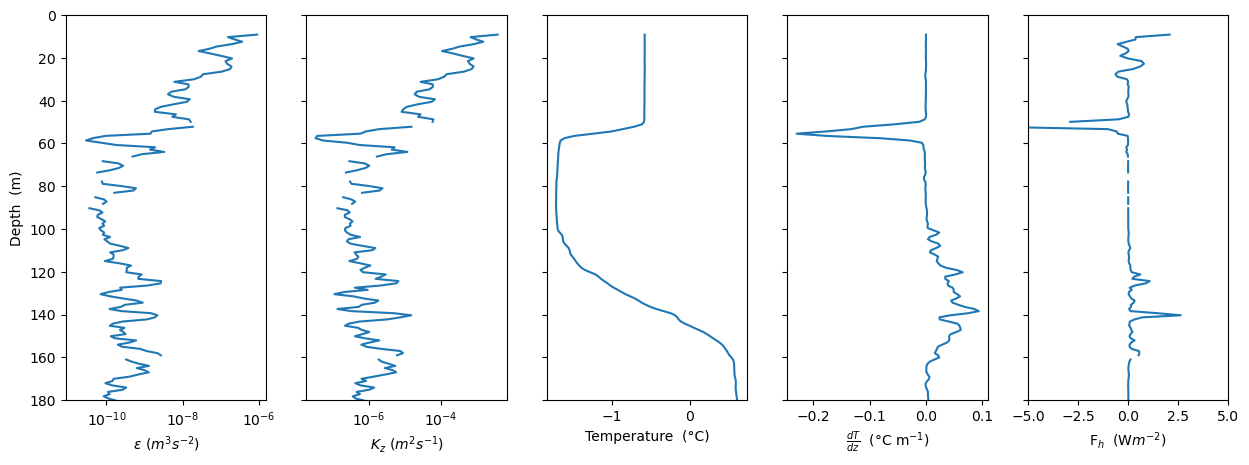

In [63]:
fig,ax=plt.subplots(1,5,figsize=(15,5),sharey=True)

rho0=1000
cp=4000

ax[0].plot(dat_wL4.EPSI_FINAL,dat_wL4.PRES)
ax[0].set_xscale('log')

ax[1].plot(Kz,dat_wL4.PRES)
ax[1].set_xscale('log')
ax[2].plot(dat_wL4.TEMP,dat_wL4.PRES)
ax[3].plot((np.gradient(dat_wL4.TEMP)/np.gradient(dat_wL4.PRES)),dat_wL4.PRES)
ax[4].plot(rho0*cp*Kz*(np.gradient(dat_wL4.TEMP)/np.gradient(dat_wL4.PRES)),dat_wL4.PRES)
ax[4].set_xlim(-5,5)
ax[3].set_ylim(180,0)

ax[0].set_ylabel('Depth  (m)')
ax[0].set_xlabel('$\epsilon \ (m^3s^{-2})$')
ax[1].set_xlabel('$K_z \ (m^2s^{-1})$')
ax[2].set_xlabel('Temperature  (°C)')
ax[3].set_xlabel(r'$\frac{dT}{dz}$  (°C m$^{-1}$)')
ax[4].set_xlabel('F$_h$  (W$m^{-2})$')




#### Compare the law-of-the-wall model for turbulent dissipation in a boundary layer with the observations

Law of the wall:

$$
\epsilon = \frac{u_*^3}{\kappa z}
$$

2.7) What are the main assumptions of law-of-the-wall?

2.8) Up to what depth does law-of-the-wall agree with observations?

2.9) Given $B_0 = 1 \times 10^{-8} \ m^3 s^{-2}$, compute the Monin-Obukhov length scale and make a statement about the forcing conditions experienced while this profile was taken. 

$$
L_{MO} = \frac{u_*^3}{\kappa B_0},
$$


$z/L_{MO}<0.3$ , wind driven shear production  
$z/L_{MO}>1$ , buoyancy dominated (production or consumption)

In [76]:

# example
z=5
ustar=0.01
B=1e-8
L_MO=(ustar**3/(0.4*1e-8))
z/(ustar**3/(0.4*1e-8)) #z/L_MO less than 0.3, therefore at 5m the turbulence produciton is wind driven and L.O.W should apply 


0.019999999999999997

In [77]:
# model profile
z=np.arange(0,80,1)
k=0.4
ustar=0.01
eps_low=ustar**3/(k*z)
eps_low_2x=eps_low*2
eps_low_2s=eps_low*0.5

/var/folders/1q/qmm9yg_90xl7f60v6q7wn2fr0000gn/T/ipykernel_46724/2175224984.py:5: RuntimeWarning: divide by zero encountered in divide
  eps_low=ustar**3/(k*z)


<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
/var/folders/1q/qmm9yg_90xl7f60v6q7wn2fr0000gn/T/ipykernel_46724/2234889368.py:12: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$ [W kg$^{-1}$]')


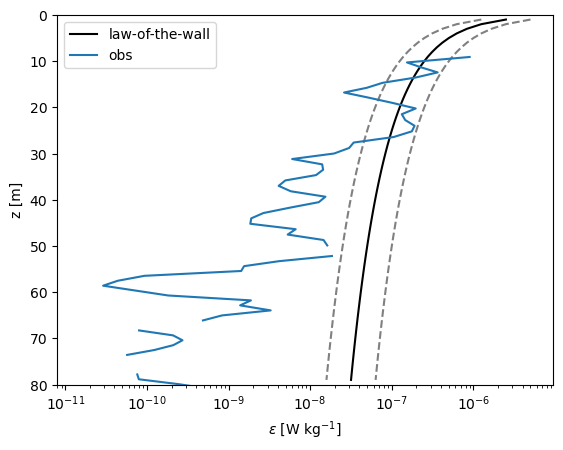

In [78]:
plt.figure()

plt.plot(eps_low,z,c='k',label='law-of-the-wall')
plt.plot(eps_low_2x,z,c='grey',ls='--')
plt.plot(eps_low_2s,z,c='grey',ls='--')


plt.plot(dat_wL4.EPSI_FINAL,dat_wL4.PRES,label='obs')
plt.xscale('log')
plt.ylim(80,0)
plt.ylabel('z [m]')
plt.xlabel('$\epsilon$ [W kg$^{-1}$]')
plt.legend()